In [1]:
import pandas as pd
from IPython.display import SVG
import numpy as np
import os

from sklearn import model_selection
from sklearn import metrics

from keras import layers
from keras import models
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras import backend as K

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train.csv')


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df['question1'] = df['question1'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')
df['question2'] = df['question2'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')

In [5]:
df_train, df_val = model_selection.train_test_split(df)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df_train['question1'], df_train['question2']]))

word_index = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word_index)))

Found 75356 unique tokens.


In [7]:
embeddings_index = {}

f = open(os.path.join('/home/eric/data', 'glove.42B.300d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in word_index:
        embeddings_index[word] = coefs

f.close()

print('Found {0} word vectors.'.format(len(embeddings_index)))

Found 66697 word vectors.


In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Siamese MaLSTM

Inspired from [How to predict Quora Question Pairs using Siamese Manhattan LSTM](https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/eric/code/venvs/data3/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


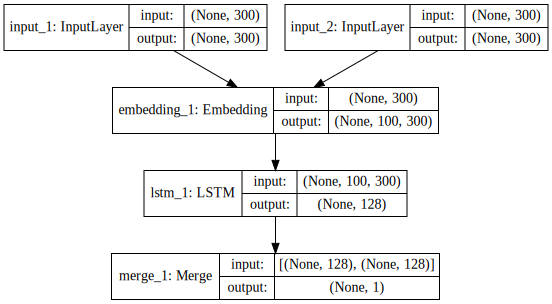

In [10]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

shared_embedding = layers.Embedding(input_dim=len(word_index) + 1,
                                    output_dim=300,
                                    weights=[embedding_matrix],
                                    input_length=100,
                                    trainable=False)

shared_lstm = layers.LSTM(128)

x1a = layers.Input(shape=(300,), dtype='int32')
h1a = shared_embedding(x1a)
h1a = shared_lstm(h1a)

x1b = layers.Input(shape=(300,), dtype='int32')
h1b = shared_embedding(x1b)
h1b = shared_lstm(h1b)

malstm_distance = layers.merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                               output_shape=lambda x: (x[0][0], 1),
                               inputs=[h1a, h1b])

model = models.Model(inputs=[x1a, x1b],
                     outputs=[malstm_distance])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
x_train1 = pad_sequences(tokenizer.texts_to_sequences(df_train['question1']), 300)
x_train2 = pad_sequences(tokenizer.texts_to_sequences(df_train['question2']), 300)

x_val1 = pad_sequences(tokenizer.texts_to_sequences(df_val['question1']), 300)
x_val2 = pad_sequences(tokenizer.texts_to_sequences(df_val['question2']), 300)

In [15]:
model.fit(x=[x_train1, x_train2],
          y=df_train['is_duplicate'].values,
          validation_data=([x_val1, x_val2], df_val['is_duplicate'].values),
          epochs=3)

Train on 303217 samples, validate on 101073 samples
Epoch 1/3
  7424/303217 [..............................] - ETA: 3:49:02 - loss: 0.2465 - acc: 0.6814

KeyboardInterrupt: 

In [15]:
metrics.roc_auc_score(list(map(lambda r: 1 if r > 0.5 else 0, model.predict([x_val1, x_val2]))),
                      df_val['is_duplicate'].values)

0.7396766683312893